# Loading the database in Julia

In [7]:
using SQLite
using NPZ
using Images
using Plots

┌ Info: Precompiling NPZ [15e1cf62-19b3-5cfa-8e77-841668bca605]
└ @ Base loading.jl:1186


In [2]:
db = SQLite.DB("pix2.db")

SQLite.DB("pix2.db")

In [3]:
res = SQLite.query(db,"select W,pic from static order by random() limit 10");

┌ Warning: `SQLite.query(db, sql)` will return an `SQLite.Query` object in the future; to materialize a resultset, do `DataFrame(SQLite.query(db, sql))` instead
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: `SQLite.Source(db, sql)` is deprecated in favor of `SQLite.Query(db, sql)` which executes a query and returns a row iterator
│   caller = ip:0x0
└ @ Core :-1


10×2 DataFrame. Omitted printing of 1 columns
│ Row │ W         │
│     │ Float64⍰  │
├─────┼───────────┤
│ 1   │ 0.282629  │
│ 2   │ 0.0670824 │
│ 3   │ 0.226789  │
│ 4   │ 0.291783  │
│ 5   │ 0.0862926 │
│ 6   │ 0.717705  │
│ 7   │ 0.598899  │
│ 8   │ 0.122897  │
│ 9   │ 0.154047  │
│ 10  │ 0.42073   │

SQLite returns DataFrames that have named fields (but raises a deprecation warning that we have to do it explicitly.)

In [48]:
res.W

10-element Array{Union{Missing, Float64},1}:
 0.2826292351964359 
 0.0670823870588104 
 0.22678946305975972
 0.2917827225255462 
 0.08629263166072715
 0.7177051283946637 
 0.5988988173434551 
 0.12289705983063873
 0.15404696697152717
 0.4207304797689587 

The results are serialized Numpy arrays:

In [50]:
blob1 = res.pic[1];
img = NPZ.npzreadarray(IOBuffer(blob1));

We can use the Images call,

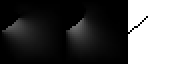

In [52]:
colorview(Gray,hcat([img[:,:,i] for i in 1:3]...) )

or the heatmap call to look at them:

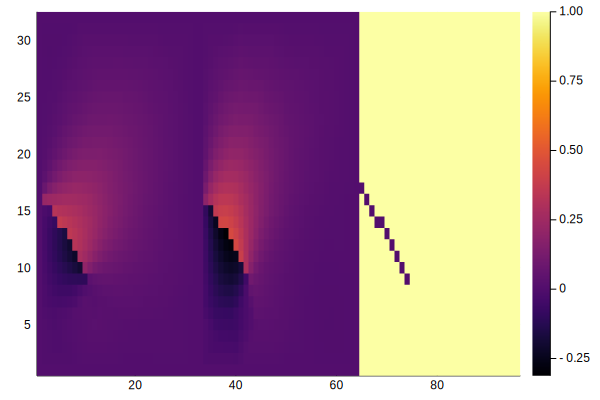

In [43]:
heatmap(hcat([img[:,:,i] for i in 1:3]...))